In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
import xgboost
from sklearn.ensemble import VotingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [81]:
nasa=pd.read_csv('nasa.csv')

In [82]:
nasa.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [83]:
#Dropping features (just in different unit or constant) - total 14
nasa.drop(["Est Dia in M(min)","Est Dia in M(max)","Est Dia in Miles(min)","Est Dia in Miles(max)",
           "Est Dia in Feet(min)","Est Dia in Feet(max)","Relative Velocity km per sec","Miles per hour",
           "Miss Dist.(kilometers)","Miss Dist.(lunar)","Miss Dist.(miles)","Orbital Period",
           "Aphelion Dist","Epoch Osculation",],axis=1,inplace=True)

In [84]:
#Dropping features (same value or irrelevent) - total 6
nasa.drop(["Neo Reference ID","Name","Orbiting Body","Close Approach Date",
           "Equinox","Orbit Determination Date",],axis=1,inplace=True)

In [88]:
nasa.head()

,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Epoch Date Close Approach,Relative Velocity km per hr,Miss Dist.(Astronomical),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Perihelion Distance,Perihelion Arg,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.6,0.127220,0.284472,788947200000,22017.003799,0.419483,17,5,0.025282,4.634,0.425549,1.407011,6.025981,314.373913,0.808259,57.257470,2.458162e+06,264.837533,0.590551,True
1,21.3,0.146068,0.326618,788947200000,65210.346095,0.383014,21,3,0.186935,5.457,0.351674,1.107776,28.412996,136.717242,0.718200,313.091975,2.457795e+06,173.741112,0.845330,False
2,20.3,0.231502,0.517654,789552000000,27326.560182,0.050956,22,0,0.043058,4.557,0.348248,1.458824,4.237961,259.475979,0.950791,248.415038,2.458120e+06,292.893654,0.559371,True
3,27.4,0.008801,0.019681,790156800000,40225.948191,0.285322,7,6,0.005512,5.093,0.216578,1.255903,7.905894,57.173266,0.983902,18.707701,2.457902e+06,68.741007,0.700277,False
4,21.6,0.127220,0.284472,790156800000,35426.991794,0.407832,25,1,0.034798,5.154,0.210448,1.225615,16.793382,84.629307,0.967687,158.263596,2.457814e+06,135.142133,0.726395,True


In [86]:
#train test split

X=nasa.drop(['Hazardous'],axis=1)
y=nasa["Hazardous"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify = y)

In [91]:
 def baseliner (x,y,cv=3,metric='neg_log_loss'):
        print('Baseline Models \n')
        print('Loss\t\t', '|\t','Model_name')
        print('='*50)
        
        models = [SVC(probability=True),DecisionTreeClassifier(),ExtraTreeClassifier()
                  ,ExtraTreesClassifier(),RandomForestClassifier(),AdaBoostClassifier(),BaggingClassifier()
                  ,GradientBoostingClassifier(),xgboost.XGBClassifier(),xgboost.XGBRFClassifier()]
        for i in models:
            model=i
            score=cross_val_score(model,x,y,scoring=metric)
            model_name= str(i).split('(')[0]
            s=str(score.mean())[:12]
            print(s+' \t'+ ' |\t'+model_name)
        print('='*50)

In [92]:
baseliner(X_train,y_train) 

Baseline Models 

Loss		 |	 Model_name
-0.441246436 	 |	SVC
-0.210604732 	 |	DecisionTreeClassifier
-3.001122441 	 |	ExtraTreeClassifier
-0.108684588 	 |	ExtraTreesClassifier
-0.039044732 	 |	RandomForestClassifier
-0.304330858 	 |	AdaBoostClassifier
-0.038880759 	 |	BaggingClassifier
-0.012960529 	 |	GradientBoostingClassifier
-0.016426140 	 |	XGBClassifier
-0.135208434 	 |	XGBRFClassifier


In [93]:
# gradient boost and xgboost 

In [112]:
gb=GradientBoostingClassifier(max_depth=3)
gb.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [113]:
y_pred = gb.predict(X_test)

In [114]:
y_pred

array([False, False, False, ..., False,  True, False])

In [115]:
confusion_matrix(y_test,y_pred)

array([[1179,    1],
       [   2,  225]])

In [116]:
classification_report(y_test,y_pred,output_dict=True)

{'False': {'precision': 0.9983065198983911,
  'recall': 0.9991525423728813,
  'f1-score': 0.9987293519695044,
  'support': 1180},
 'True': {'precision': 0.995575221238938,
  'recall': 0.9911894273127754,
  'f1-score': 0.9933774834437086,
  'support': 227},
 'accuracy': 0.997867803837953,
 'macro avg': {'precision': 0.9969408705686646,
  'recall': 0.9951709848428283,
  'f1-score': 0.9960534177066065,
  'support': 1407},
 'weighted avg': {'precision': 0.9978658626164467,
  'recall': 0.997867803837953,
  'f1-score': 0.9978659019656978,
  'support': 1407}}

In [118]:
f=gb.feature_importances_

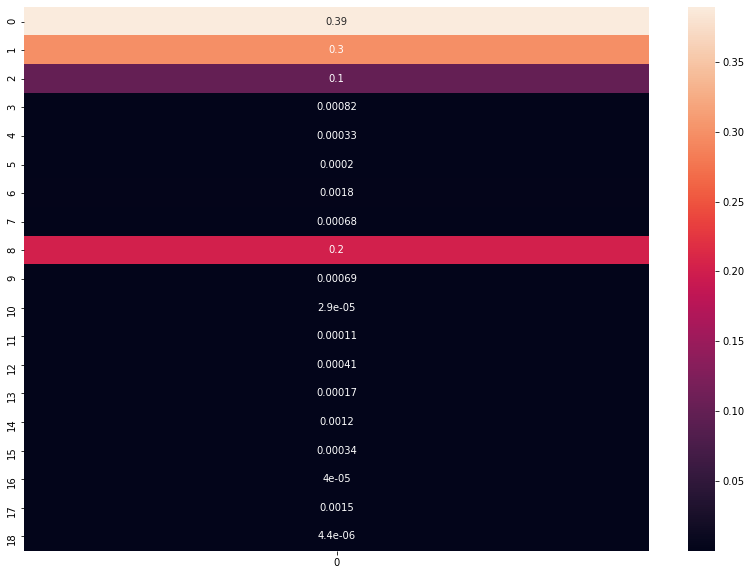

In [121]:
plt.figure(figsize=(14,10))
sns.heatmap(f.reshape(19,1),annot=True)
plt.show()

In [122]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3280 entries, 96 to 2547
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Absolute Magnitude           3280 non-null   float64
 1   Est Dia in KM(min)           3280 non-null   float64
 2   Est Dia in KM(max)           3280 non-null   float64
 3   Epoch Date Close Approach    3280 non-null   int64  
 4   Relative Velocity km per hr  3280 non-null   float64
 5   Miss Dist.(Astronomical)     3280 non-null   float64
 6   Orbit ID                     3280 non-null   int64  
 7   Orbit Uncertainity           3280 non-null   int64  
 8   Minimum Orbit Intersection   3280 non-null   float64
 9   Jupiter Tisserand Invariant  3280 non-null   float64
 10  Eccentricity                 3280 non-null   float64
 11  Semi Major Axis              3280 non-null   float64
 12  Inclination                  3280 non-null   float64
 13  Asc Node Longitud